In [ ]:
%matplotlib inline
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=6efdba9445efcf7e4119aa5302d376cbcd6c093d989405e8b2523e59851576c4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import wget
import zipfile

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Load Data

<!-- .. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory. -->

In [ ]:
import shutil
data_dir = 'hymenoptera_data'

if os.path.exists(data_dir):
    shutil.rmtree(data_dir) # make sure there is nothing in our folder

os.makedirs(data_dir) # create folders
wget.download("https://download.pytorch.org/tutorial/hymenoptera_data.zip",
              data_dir) # download dataset
with zipfile.ZipFile(os.path.join(data_dir, "hymenoptera_data.zip"), 'r') as zip_ref:
    zip_ref.extractall(".") # extract dataset


In [ ]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
      transforms.RandomResizedCrop(224, [0.75, 1.0]),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
# Just normalization for validation
val_transforms = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

train_dir = os.path.join(data_dir, "train")
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=train_transforms)
val_dir = os.path.join(data_dir, "val")
val_dataset = datasets.ImageFolder(root=val_dir,
                                   transform=val_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)

print("Dataset sizes:", train_size, val_size )

class_names = train_dataset.classes

print("Class names:", class_names)

Dataset sizes: 244 153
Class names: ['ants', 'bees']


Now we have to create the dataloader, as we in the previous lab for the logistic regression. Notice however that we are using one extra parameter:

*   ``num_workers`` is used to *parallelize* the loading from disk.

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 4 threads to load the 16 images in parallel (4 per thread).


In [ ]:
batch_size = 16
train_dl = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                       batch_size=batch_size, num_workers=4)
val_dl = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size*2, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand *data
augmentation*.



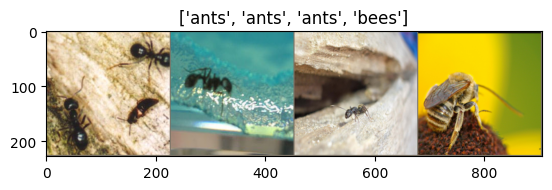

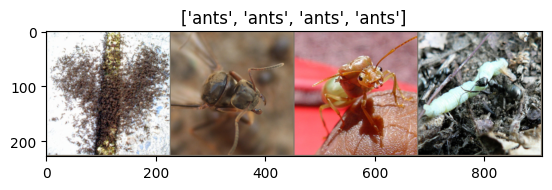

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # reconvert to numpy tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                  # take out normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)                   # pause a bit so that plots are updated


# Get a batch of training data
x, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images

imshow(out, title=[class_names[c] for c in classes[:4]])

# Redo for valid data
x, classes = next(iter(val_dl))
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=[class_names[c] for c in classes[:4]])

As you may notice the images in the first row (corresponding to the training data batch) are not centerd and colors are slightly changed.  

## Training the model

Now, let's write a general function to train a model. As you can see is very similar to the function that we used to train the Logistic Regresion model. However I preferred to put the training step and the evaluation step in two distinct function to better structure the code.

In [ ]:
# Function to iterate over data while training
def train_one_epoch(model, train_dl, loss, optim, device):
    model.train()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)

        ####################
        ## Your code here ##
        ####################

        # zero the parameter gradients
        optim.zero_grad()

        # forward
        outputs = model(x)
        preds = torch.argmax(outputs,1)
        l = loss(outputs,y)

        # backward + optimize
        l.backward()
        optim.step()

        ####################
        ##      FIN        #
        ####################

        # statistics
        cur_loss += l.item() * x.size(0)
        cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(train_dl.dataset)
    epoch_acc = cur_acc.double() / len(train_dl.dataset)
    return epoch_loss, epoch_acc

# Function to iterate over data while evaluating
def eval_one_epoch(model, val_dl, loss, device):
    model.eval()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)

            ####################
            ## Your code here ##
            ####################

            # forward
            outputs = model(x)
            preds = torch.argmax(outputs,1)
            l = loss(outputs,y)

            ####################
            ##      FIN        #
            ####################

            # statistics
            cur_loss += l.item() * x.size(0)
            cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(val_dl.dataset)
    epoch_acc = cur_acc.double() / len(val_dl.dataset)
    return epoch_loss, epoch_acc

def train_model(model, train_dl, val_dl, loss, optim, num_epochs=25):
    model.to(device)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_loss, train_acc = train_one_epoch(model, train_dl, loss, optim, device)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        val_loss, val_acc = eval_one_epoch(model, val_dl, loss, device)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        # save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "temp_model.pt")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load("temp_model.pt"))
    return model

### Visualizing the model predictions

Generic function to display model  predictions for a few images.




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (x, y) in enumerate(val_dl):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            for j in range(x.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(x.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Training a CNN from scratch
We will use the simplest of the ResNet models, the ResNet18 ([link](https://arxiv.org/abs/1512.03385) to the paper).

To do so, we simply instantiate the model (``torchvision.models.resnet18(num_classes=2)``) as we used to do also for the Logistic regression and we train it for a few epochs. Remember as well to:


*   Select the loss to employ
*   Instantiate an optimizer

The complete training (for 20 epochs) should take about 1-2 mins.





In [ ]:
model = models.resnet18(num_classes=2)
model = model.to(device)

loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Train and evaluate
model = train_model(model, train_dl, val_dl, loss, optimizer,
                       num_epochs=20)

Epoch 0/19
----------
Train Loss: 0.7408 Acc: 0.5656
Val Loss: 0.6254 Acc: 0.6340

Epoch 1/19
----------
Train Loss: 0.5882 Acc: 0.6885
Val Loss: 0.8971 Acc: 0.4771

Epoch 2/19
----------
Train Loss: 0.6034 Acc: 0.6434
Val Loss: 0.5442 Acc: 0.7059

Epoch 3/19
----------
Train Loss: 0.5079 Acc: 0.7336
Val Loss: 0.5209 Acc: 0.7059

Epoch 4/19
----------
Train Loss: 0.4887 Acc: 0.7787
Val Loss: 0.5179 Acc: 0.7190

Epoch 5/19
----------
Train Loss: 0.5169 Acc: 0.7213
Val Loss: 0.5268 Acc: 0.7386

Epoch 6/19
----------
Train Loss: 0.4342 Acc: 0.7746
Val Loss: 0.6114 Acc: 0.6732

Epoch 7/19
----------
Train Loss: 0.4157 Acc: 0.8115
Val Loss: 0.5342 Acc: 0.6993

Epoch 8/19
----------
Train Loss: 0.3692 Acc: 0.8402
Val Loss: 0.5163 Acc: 0.7320

Epoch 9/19
----------
Train Loss: 0.3930 Acc: 0.8279
Val Loss: 0.7240 Acc: 0.7320

Epoch 10/19
----------
Train Loss: 0.3021 Acc: 0.8770
Val Loss: 0.7003 Acc: 0.7516

Epoch 11/19
----------
Train Loss: 0.3519 Acc: 0.8320
Val Loss: 1.2412 Acc: 0.6405

Ep

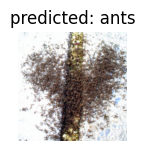

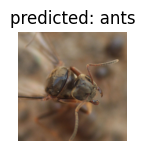

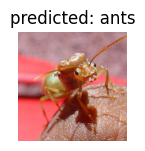

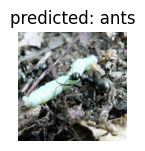

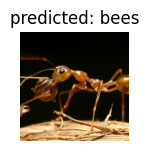

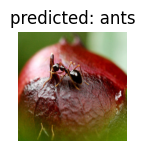

In [ ]:
visualize_model(model)

The model that we trained is not very accurate. Why? Because CNN are incredibly complex models and to be traned properly (without overfitting), they need to "see" a sufficiently large representation of the world. For this reason, most of the time we start at least from a network pretrained on the ImageNet dataset (1M samples).

## Finetune a CNN
To Finetune a CNN we need to do three steps:
*  Load the weights of the pretrained model: torchvision provides the weights pretrained Imagenet for each of the CNN implemented in the library (``weights=torchvision.models.ResNet18_Weights``).
*  Reset the final fully connected layer: to do so we initialize a linear layer ``nn.Linear()`` as the last layer of the model which is ``model_ft.fc``



In [ ]:
from torchvision.models import ResNet18_Weights

model_ft = models.resnet18(weights=ResNet18_Weights)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=1e-4)

# Train and evaluate
model_ft = train_model(model_ft, train_dl, val_dl, loss, optimizer_ft,
                       num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


Epoch 0/19
----------
Train Loss: 0.4126 Acc: 0.7951
Val Loss: 0.2757 Acc: 0.8954

Epoch 1/19
----------
Train Loss: 0.1021 Acc: 0.9631
Val Loss: 0.2286 Acc: 0.9020

Epoch 2/19
----------
Train Loss: 0.0550 Acc: 0.9836
Val Loss: 0.2148 Acc: 0.9281

Epoch 3/19
----------
Train Loss: 0.0142 Acc: 1.0000
Val Loss: 0.2278 Acc: 0.9346

Epoch 4/19
----------
Train Loss: 0.0216 Acc: 0.9959
Val Loss: 0.2034 Acc: 0.9281

Epoch 5/19
----------
Train Loss: 0.0075 Acc: 1.0000
Val Loss: 0.2006 Acc: 0.9216

Epoch 6/19
----------
Train Loss: 0.0183 Acc: 0.9959
Val Loss: 0.1838 Acc: 0.9346

Epoch 7/19
----------
Train Loss: 0.0300 Acc: 0.9918
Val Loss: 0.2630 Acc: 0.9150

Epoch 8/19
----------
Train Loss: 0.0183 Acc: 0.9959
Val Loss: 0.2337 Acc: 0.9412

Epoch 9/19
----------
Train Loss: 0.0119 Acc: 1.0000
Val Loss: 0.2193 Acc: 0.9477

Epoch 10/19
----------
Train Loss: 0.0574 Acc: 0.9877
Val Loss: 0.2360 Acc: 0.9281

Epoch 11/19
----------
Train Loss: 0.0733 Acc: 0.9795
Val Loss: 0.3095 Acc: 0.8889

Ep

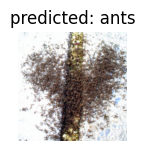

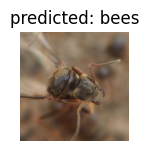

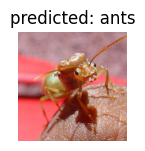

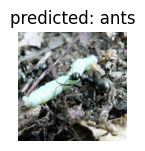

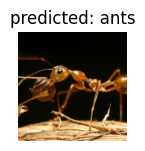

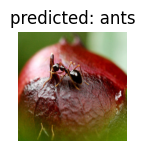

In [ ]:
visualize_model(model_ft)

Indeed it seems that pretraining is working effectively. We got a pretty good validation accuracy (>90%).

## ConvNet as fixed feature extractor
In this case we only train the last layer of the network. For this reason we need to:

*  Pass to the optimizer only the weights of last layer ( ``model_fe.fc.parameters()``)
*  Freeze all the network except the final layer, by seting ``requires_grad = False`` to freeze the parameters so that the gradients are not computed in ``backward()`` and speed up the computation. You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

To train it will take less time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward still needs to be computed.


In [ ]:
model_fe = models.resnet18(weights=ResNet18_Weights)

# We want to freeze model_fe's parameters
for param in model_fe.parameters():
  param.requires_grad=False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, 2)

model_fe = model_fe.to(device)

# Only parameters of final layer are being optimized as opposed to before
optimizer_fe = optim.AdamW(model_fe.fc.parameters(), lr=1e-3)

# Train and evaluate
model_fe = train_model(model_fe, train_dl, val_dl, loss, optimizer_fe,
                         num_epochs=20)

AttributeError: ignored

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We actually got a better result with the CNN as Feature Extractor (about 95 %)!

This is most likely due to the fact that in the previous case we were strongly overfitting the data distribution. Indeed, by modifying also the hidden layers, the model at hand is incredibly complex for the small ant-bees dataset. Therefore if you have small dataset is better to only train the last fc layer.

In [ ]:
visualize_model(model_fe)

plt.ioff()
plt.show()

## But is it really necessary then to use the whole network?
No it is not. When doing transfer learning we can preprocess our datasets by passing the images through the convolutional layers.


In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

cnn_model = models.resnet18(weights=ResNet18_Weights)
cnn_model.fc = torch.nn.Identity()

def extract_features(model, dl, device):
    model.to(device)
    x_extr, y_extr = [], []
    with torch.no_grad():
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            preds = cnn_model(x)
            x_extr.append(preds)
            y_extr.append(y)
        x_extr = torch.cat(x_extr, dim=0)
        y_extr = torch.cat(y_extr, dim=0)
        dataset_extr = TensorDataset(x_extr, y_extr)
    return dataset_extr

# Extract the training dataset
trainset_extr = extract_features(cnn_model, train_dl, device)
train_dl_extr = DataLoader(trainset_extr, batch_size=16, shuffle=True)

# Extract the validation dataset
valset_extr = extract_features(cnn_model, val_dl, device)
val_dl_extr = DataLoader(trainset_extr, batch_size=16)

The extracted features can now be used to train only a linear layer (i.e., a logistic regression).

In [ ]:
model_fe2 = nn.Linear(num_ftrs, 2)
optimizer_fe2 = optim.Adam(model_fe2.parameters())

train_model(model_fe2, train_dl_extr, val_dl_extr, loss, optimizer_fe2, num_epochs=20)

We are several **order of magnitudes faster** (about 1s the whole training) than passing the data every time through the network.

Also, the performance are even higher than previously. This is related to the losing the data augmentation: the training set now is fixed and it seems that the data augmentation that we were using earlier was actually dangeruous.

> When using the resnet as a feature extractor, the training accuracy was always **lower** that the validation accuracy. It means that you are regularizing too much your model (by means of the data augmentation) and you are not allowing it to fit the data.

